In [10]:
"""
================================================================================
PROYECTO FINAL - INTELIGENCIA ARTIFICIAL
SECCIÓN 2: PREPROCESAMIENTO DE DATOS (TAREAS 6, 7, 8)
================================================================================
Universidad del Norte - Ingeniería de Sistemas
Profesor: Eduardo Zurek, Ph.D.

OBJETIVO: Preparar los datos para modelado mediante tratamiento de missing
values, codificación, normalización, split train/test y PCA.
================================================================================
"""

# ============================================
# CONFIGURACIÓN INICIAL
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import json
import pickle

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
TARGET_COLUMN = 'DESEMP_INGLES'

print("="*80)
print("SECCIÓN 2: PREPROCESAMIENTO DE DATOS")
print("="*80)
print(f"📌 Random State: {RANDOM_STATE}")
print(f"🎯 Variable Objetivo: {TARGET_COLUMN}\n")

# ============================================
# CARGAR DATOS Y CHECKPOINT ANTERIOR
# ============================================

print("="*80)
print("CARGANDO DATOS Y VARIABLES SELECCIONADAS")
print("="*80 + "\n")

# Cargar dataset
try:
    df = pd.read_csv('dataset_saber11_reducido_estratificado.csv')
    print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
except FileNotFoundError:
    print("❌ Error: No se encontró el dataset.")
    raise

# Cargar variables seleccionadas
try:
    with open('checkpoint_seccion1_completa.json', 'r') as f:
        checkpoint = json.load(f)
    selected_features = checkpoint['variables_seleccionadas_modelado']
    print(f"\n✅ Variables seleccionadas: {len(selected_features)}")
except:
    selected_features = [
        'PUNT_GLOBAL', 'PUNT_C_NATURALES', 'PUNT_LECTURA_CRITICA',
        'PUNT_SOCIALES_CIUDADANAS', 'PUNT_MATEMATICAS',
        'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'COLE_NATURALEZA',
        'FAMI_TIENEAUTOMOVIL', 'FAMI_EDUCACIONMADRE'
    ]

# Verificar variables
selected_features = [v for v in selected_features if v in df.columns]
df_model = df[selected_features + [TARGET_COLUMN]].copy()

print(f"✅ Dataset para modelado: {df_model.shape}")


SECCIÓN 2: PREPROCESAMIENTO DE DATOS
📌 Random State: 42
🎯 Variable Objetivo: DESEMP_INGLES

CARGANDO DATOS Y VARIABLES SELECCIONADAS

✅ Dataset cargado: 217,581 filas × 51 columnas

✅ Variables seleccionadas: 10
✅ Dataset para modelado: (217581, 11)
✅ Dataset cargado: 217,581 filas × 51 columnas

✅ Variables seleccionadas: 10
✅ Dataset para modelado: (217581, 11)


In [11]:

# ============================================
# TAREA 6: PREPROCESAMIENTO
# ============================================

print("\n\n" + "="*80)
print("TAREA 6: TRATAMIENTO, CODIFICACIÓN Y NORMALIZACIÓN")
print("="*80 + "\n")

# 6.1: Análisis de Missing Values
print("6.1 ANÁLISIS DE VALORES FALTANTES")
print("-" * 80 + "\n")

missing_info = pd.DataFrame({
    'Variable': df_model.columns,
    'N_Missing': df_model.isnull().sum().values,
    'Pct_Missing': (df_model.isnull().sum().values / len(df_model) * 100).round(2)
}).sort_values('N_Missing', ascending=False)

missing_vars = missing_info[missing_info['N_Missing'] > 0]

if len(missing_vars) > 0:
    print("Variables con valores faltantes:\n")
    print(missing_vars.to_string(index=False))
else:
    print("✅ No hay valores faltantes")

# 6.2: Clasificar variables
print("\n\n6.2 CLASIFICACIÓN DE VARIABLES")
print("-" * 80 + "\n")

numeric_features = df_model[selected_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_model[selected_features].select_dtypes(include=['object']).columns.tolist()

print(f"Numéricas: {len(numeric_features)}")
for v in numeric_features:
    print(f"   • {v}")

print(f"\nCategóricas: {len(categorical_features)}")
for v in categorical_features:
    print(f"   • {v} ({df_model[v].nunique()} categorías)")

# 6.3: Imputación
print("\n\n6.3 IMPUTACIÓN DE VALORES FALTANTES")
print("-" * 80 + "\n")

df_imputed = df_model.copy()

for col in numeric_features:
    n_missing = df_imputed[col].isnull().sum()
    if n_missing > 0:
        df_imputed[col].fillna(df_imputed[col].median(), inplace=True)
        print(f"✅ {col}: Imputados {n_missing} con mediana")

for col in categorical_features:
    n_missing = df_imputed[col].isnull().sum()
    if n_missing > 0:
        mode_val = df_imputed[col].mode()[0] if len(df_imputed[col].mode()) > 0 else 'DESCONOCIDO'
        df_imputed[col].fillna(mode_val, inplace=True)
        print(f"✅ {col}: Imputados {n_missing} con moda")

# 6.4: Codificación
print("\n\n6.4 CODIFICACIÓN DE VARIABLES CATEGÓRICAS")
print("-" * 80 + "\n")

df_encoded = df_imputed.copy()
label_encoders = {}
encoded_columns = []

# Codificar target
le_target = LabelEncoder()
df_encoded[TARGET_COLUMN + '_encoded'] = le_target.fit_transform(df_encoded[TARGET_COLUMN])
target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print(f"🎯 Target: {target_mapping}\n")

# Codificar categóricas
for col in categorical_features:
    n_unique = df_encoded[col].nunique()
    
    if n_unique <= 2:
        le = LabelEncoder()
        df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le
        encoded_columns.append(col + '_encoded')
        print(f"✅ {col}: Label Encoding")
    else:
        dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        encoded_columns.extend(dummies.columns.tolist())
        print(f"✅ {col}: One-Hot Encoding → {len(dummies.columns)} columnas")

final_features = numeric_features + encoded_columns
print(f"\n✅ Features finales: {len(final_features)}")

# 6.5: Normalización
print("\n\n6.5 NORMALIZACIÓN")
print("-" * 80 + "\n")

X = df_encoded[final_features].copy()
y = df_encoded[TARGET_COLUMN + '_encoded'].copy()
y_original = df_encoded[TARGET_COLUMN].copy()

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

print("✅ StandardScaler aplicado")
print("\nEstadísticas post-escalado:\n")
print(X_scaled[numeric_features].describe().round(3))

# Guardar objetos
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'label_encoder_target': le_target,
    'target_mapping': target_mapping,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'final_features': final_features
}

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print("\n💾 Guardado: preprocessing_objects.pkl")

print("\n" + "="*80)
print("✅ TAREA 6 COMPLETADA")
print("="*80)





TAREA 6: TRATAMIENTO, CODIFICACIÓN Y NORMALIZACIÓN

6.1 ANÁLISIS DE VALORES FALTANTES
--------------------------------------------------------------------------------

Variables con valores faltantes:

            Variable  N_Missing  Pct_Missing
  FAMI_TIENEINTERNET      12214         5.61
 FAMI_EDUCACIONMADRE      12004         5.52
 FAMI_TIENEAUTOMOVIL       7101         3.26
FAMI_TIENECOMPUTADOR       6668         3.06


6.2 CLASIFICACIÓN DE VARIABLES
--------------------------------------------------------------------------------

Numéricas: 5
   • PUNT_GLOBAL
   • PUNT_C_NATURALES
   • PUNT_LECTURA_CRITICA
   • PUNT_SOCIALES_CIUDADANAS
   • PUNT_MATEMATICAS

Categóricas: 5
   • FAMI_TIENEINTERNET (2 categorías)
   • FAMI_TIENECOMPUTADOR (2 categorías)
   • COLE_NATURALEZA (2 categorías)
   • FAMI_TIENEAUTOMOVIL (2 categorías)
   • FAMI_EDUCACIONMADRE (12 categorías)


6.3 IMPUTACIÓN DE VALORES FALTANTES
---------------------------------------------------------------------------

In [12]:

# ============================================
# TAREA 7: DIVISIÓN TRAIN/TEST
# ============================================

print("\n\n" + "="*80)
print("TAREA 7: DIVISIÓN TRAIN/TEST ESTRATIFICADA")
print("="*80 + "\n")

TEST_SIZE = 0.30

print(f"📊 Configuración: 70% Train / 30% Test")
print(f"   Estratificación: Por {TARGET_COLUMN}\n")

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

y_train_original = y_original.loc[X_train.index]
y_test_original = y_original.loc[X_test.index]

print(f"✅ Train: {X_train.shape[0]:,} obs ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✅ Test:  {X_test.shape[0]:,} obs ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verificar estratificación
print("\n7.2 VERIFICACIÓN DE ESTRATIFICACIÓN")
print("-" * 80 + "\n")

dist_original = y.value_counts(normalize=True).sort_index() * 100
dist_train = y_train.value_counts(normalize=True).sort_index() * 100
dist_test = y_test.value_counts(normalize=True).sort_index() * 100

verification_df = pd.DataFrame({
    'Clase': le_target.inverse_transform(dist_original.index),
    'Original_%': dist_original.values,
    'Train_%': dist_train.values,
    'Test_%': dist_test.values
}).round(2)

print(verification_df.to_string(index=False))

# Guardar
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_frame(name='target').to_csv('y_train.csv', index=False)
y_test.to_frame(name='target').to_csv('y_test.csv', index=False)

train_test_data = {
    'X_train': X_train, 'X_test': X_test,
    'y_train': y_train, 'y_test': y_test,
    'y_train_original': y_train_original,
    'y_test_original': y_test_original
}

with open('train_test_split.pkl', 'wb') as f:
    pickle.dump(train_test_data, f)

print("\n💾 Archivos guardados")

print("\n" + "="*80)
print("✅ TAREA 7 COMPLETADA")
print("="*80)




TAREA 7: DIVISIÓN TRAIN/TEST ESTRATIFICADA

📊 Configuración: 70% Train / 30% Test
   Estratificación: Por DESEMP_INGLES

✅ Train: 152,306 obs (70.0%)
✅ Test:  65,275 obs (30.0%)

7.2 VERIFICACIÓN DE ESTRATIFICACIÓN
--------------------------------------------------------------------------------

Clase  Original_%  Train_%  Test_%
   A-       49.52    49.52   49.52
   A1       28.16    28.16   28.15
   A2       14.59    14.59   14.60
   B+        1.34     1.34    1.34
   B1        6.39     6.39    6.39

💾 Archivos guardados

✅ TAREA 7 COMPLETADA

💾 Archivos guardados

✅ TAREA 7 COMPLETADA




TAREA 8: ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

📊 Varianza explicada (primeras 10 PCs):

   PC 1: 65.96% | Acumulada:  65.96%
   PC 2:  5.96% | Acumulada:  71.92%
   PC 3:  4.74% | Acumulada:  76.66%
   PC 4:  3.73% | Acumulada:  80.39%
   PC 5:  3.31% | Acumulada:  83.70%
   PC 6:  2.74% | Acumulada:  86.43%
   PC 7:  2.56% | Acumulada:  88.99%
   PC 8:  2.14% | Acumulada:  91.13%
   PC 9:  1.96% | Acumulada:  93.09%
   PC10:  1.73% | Acumulada:  94.82%

✅ Componentes óptimas: 8 (explican 91.13%)


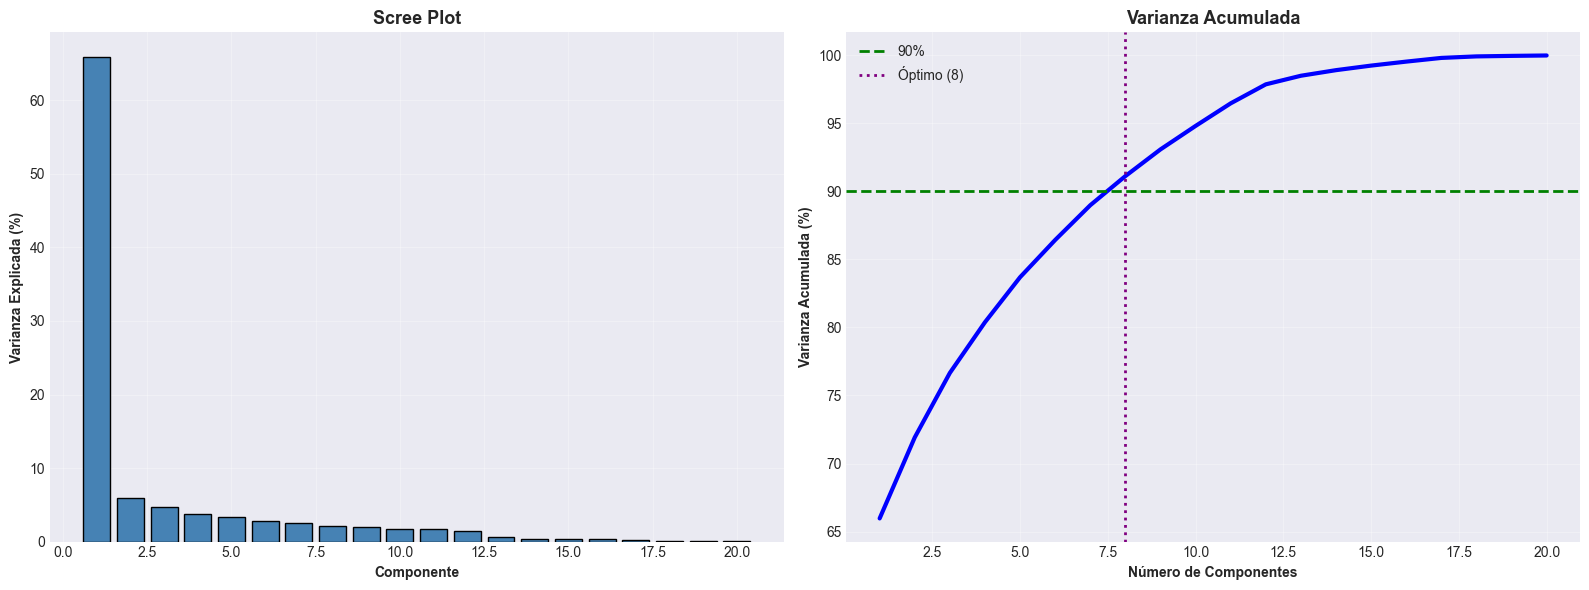


✅ PCA aplicado: (152306, 20) → (152306, 8)
   Reducción: 60.0%


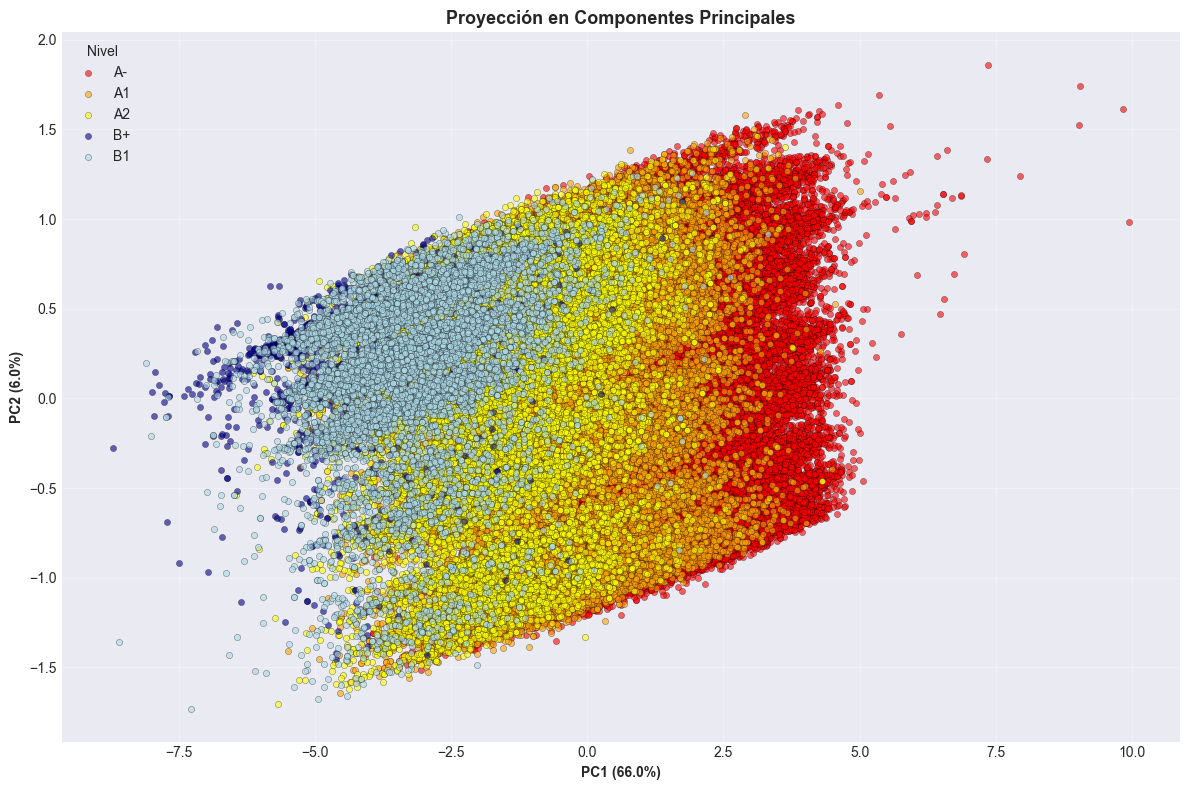


💾 Guardado: pca_models.pkl, X_train_pca.csv, X_test_pca.csv

✅ TAREA 8 COMPLETADA


In [13]:


# ============================================
# TAREA 8: PCA
# ============================================

print("\n\n" + "="*80)
print("TAREA 8: ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
print("="*80 + "\n")

# PCA completo
n_components_max = min(X_train.shape[0], X_train.shape[1])
pca_full = PCA(n_components=n_components_max, random_state=RANDOM_STATE)
X_train_pca_full = pca_full.fit_transform(X_train)

explained_variance = pca_full.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

print(f"📊 Varianza explicada (primeras 10 PCs):\n")
for i in range(min(10, len(explained_variance))):
    print(f"   PC{i+1:2d}: {explained_variance[i]:5.2f}% | Acumulada: {cumulative_variance[i]:6.2f}%")

# Seleccionar componentes óptimas
threshold_90 = np.argmax(cumulative_variance >= 90) + 1
optimal_n_components = threshold_90

print(f"\n✅ Componentes óptimas: {optimal_n_components} (explican {cumulative_variance[optimal_n_components-1]:.2f}%)")

# Scree Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

n_plot = min(20, len(explained_variance))
axes[0].bar(range(1, n_plot+1), explained_variance[:n_plot], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Componente', fontweight='bold')
axes[0].set_ylabel('Varianza Explicada (%)', fontweight='bold')
axes[0].set_title('Scree Plot', fontweight='bold', fontsize=13)
axes[0].grid(alpha=0.3)

axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-', linewidth=3)
axes[1].axhline(y=90, color='green', linestyle='--', linewidth=2, label='90%')
axes[1].axvline(x=optimal_n_components, color='purple', linestyle=':', linewidth=2, label=f'Óptimo ({optimal_n_components})')
axes[1].set_xlabel('Número de Componentes', fontweight='bold')
axes[1].set_ylabel('Varianza Acumulada (%)', fontweight='bold')
axes[1].set_title('Varianza Acumulada', fontweight='bold', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# PCA óptimo
pca_optimal = PCA(n_components=optimal_n_components, random_state=RANDOM_STATE)
X_train_pca = pca_optimal.fit_transform(X_train)
X_test_pca = pca_optimal.transform(X_test)

print(f"\n✅ PCA aplicado: {X_train.shape} → {X_train_pca.shape}")
print(f"   Reducción: {(1 - optimal_n_components/X_train.shape[1])*100:.1f}%")

# Visualización PC1 vs PC2
fig, ax = plt.subplots(figsize=(12, 8))
colors_map = {'A-': 'red', 'A1': 'orange', 'A2': 'yellow', 'B1': 'lightblue', 'B+': 'darkblue'}

for clase in le_target.classes_:
    mask = y_train_original == clase
    ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
              c=colors_map[clase], label=clase, alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

ax.set_xlabel(f'PC1 ({explained_variance[0]:.1f}%)', fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_variance[1]:.1f}%)', fontweight='bold')
ax.set_title('Proyección en Componentes Principales', fontweight='bold', fontsize=13)
ax.legend(title='Nivel')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Guardar PCA
pca_objects = {
    'pca_optimal': pca_optimal,
    'optimal_n_components': optimal_n_components,
    'explained_variance': explained_variance,
    'cumulative_variance': cumulative_variance,
    'X_train_pca': X_train_pca,
    'X_test_pca': X_test_pca
}

with open('pca_models.pkl', 'wb') as f:
    pickle.dump(pca_objects, f)

pd.DataFrame(X_train_pca).to_csv('X_train_pca.csv', index=False)
pd.DataFrame(X_test_pca).to_csv('X_test_pca.csv', index=False)

print("\n💾 Guardado: pca_models.pkl, X_train_pca.csv, X_test_pca.csv")

print("\n" + "="*80)
print("✅ TAREA 8 COMPLETADA")
print("="*80)


In [14]:
# Instalar ipympl para interactividad 3D (solo ejecutar una vez)
!pip install ipympl

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Visualización 3D del PCA - Versión INTERACTIVA (optimizada)
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# OPCIÓN 1: Plotly (más fluido e interactivo)
print("📊 Generando visualización 3D interactiva con Plotly...")

fig_plotly = go.Figure()

colors_map = {'A-': 'red', 'A1': 'orange', 'A2': 'yellow', 'B1': 'lightblue', 'B+': 'darkblue'}

for clase in le_target.classes_:
    mask = y_train_original == clase
    fig_plotly.add_trace(go.Scatter3d(
        x=X_train_pca[mask, 0],
        y=X_train_pca[mask, 1],
        z=X_train_pca[mask, 2],
        mode='markers',
        name=clase,
        marker=dict(
            size=3,
            color=colors_map[clase],
            opacity=0.7,
            line=dict(color='white', width=0.5)
        )
    ))

fig_plotly.update_layout(
    title=f'Proyección 3D en Componentes Principales (INTERACTIVA)',
    scene=dict(
        xaxis_title=f'PC1 ({explained_variance[0]:.1f}%)',
        yaxis_title=f'PC2 ({explained_variance[1]:.1f}%)',
        zaxis_title=f'PC3 ({explained_variance[2]:.1f}%)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2)),
        bgcolor='rgba(240,240,240,1)',
        xaxis=dict(backgroundcolor='rgba(240,240,240,1)', gridcolor='white', showbackground=True),
        yaxis=dict(backgroundcolor='rgba(240,240,240,1)', gridcolor='white', showbackground=True),
        zaxis=dict(backgroundcolor='rgba(240,240,240,1)', gridcolor='white', showbackground=True)
    ),
    width=1000,
    height=800,
    showlegend=True,
    legend=dict(title='Nivel'),
    paper_bgcolor='white'
)

fig_plotly.show()

print(f"\n✅ Visualización 3D INTERACTIVA completada con Plotly")
print(f"   Las primeras 3 componentes explican: {cumulative_variance[2]:.2f}% de la varianza")
print(f"\n💡 CONTROLES INTERACTIVOS:")
print(f"   🖱️  Click + arrastrar: Rotar el gráfico en 3D")
print(f"   🔍  Scroll: Zoom in/out")
print(f"   📸  Botones superiores: Guardar, zoom, pan, rotar, resetear")
print(f"   👆  Click en leyenda: Mostrar/ocultar clases")
print(f"   🎯  Hover: Ver valores exactos de cada punto")

📊 Generando visualización 3D interactiva con Plotly...



✅ Visualización 3D INTERACTIVA completada con Plotly
   Las primeras 3 componentes explican: 76.66% de la varianza

💡 CONTROLES INTERACTIVOS:
   🖱️  Click + arrastrar: Rotar el gráfico en 3D
   🔍  Scroll: Zoom in/out
   📸  Botones superiores: Guardar, zoom, pan, rotar, resetear
   👆  Click en leyenda: Mostrar/ocultar clases
   🎯  Hover: Ver valores exactos de cada punto


In [16]:



# ============================================
# RESUMEN FINAL
# ============================================

print("\n\n" + "="*80)
print("📊 RESUMEN SECCIÓN 2")
print("="*80 + "\n")

summary = f"""
✅ PREPROCESAMIENTO COMPLETADO

TAREA 6: Tratamiento y Codificación
   • Variables imputadas: {len([v for v in numeric_features + categorical_features if df_model[v].isnull().sum() > 0])}
   • Variables codificadas: {len(categorical_features)}
   • Features finales: {len(final_features)}
   • Método escalado: StandardScaler

TAREA 7: División Train/Test
   • Train: {X_train.shape[0]:,} obs (70%)
   • Test: {X_test.shape[0]:,} obs (30%)
   • Estratificación: ✅ Exitosa

TAREA 8: PCA
   • Componentes óptimas: {optimal_n_components}
   • Varianza explicada: {cumulative_variance[optimal_n_components-1]:.2f}%
   • Reducción: {(1 - optimal_n_components/X_train.shape[1])*100:.1f}%

ARCHIVOS GENERADOS:
   ✓ preprocessing_objects.pkl
   ✓ train_test_split.pkl
   ✓ pca_models.pkl
   ✓ X_train.csv, X_test.csv
   ✓ y_train.csv, y_test.csv
   ✓ X_train_pca.csv, X_test_pca.csv

PRÓXIMO PASO: Sección 3 - Aprendizaje No Supervisado
"""

print(summary)
print("="*80)
print("🎉 ¡SECCIÓN 2 COMPLETADA!")
print("="*80)




📊 RESUMEN SECCIÓN 2


✅ PREPROCESAMIENTO COMPLETADO

TAREA 6: Tratamiento y Codificación
   • Variables imputadas: 4
   • Variables codificadas: 5
   • Features finales: 20
   • Método escalado: StandardScaler

TAREA 7: División Train/Test
   • Train: 152,306 obs (70%)
   • Test: 65,275 obs (30%)
   • Estratificación: ✅ Exitosa

TAREA 8: PCA
   • Componentes óptimas: 8
   • Varianza explicada: 91.13%
   • Reducción: 60.0%

ARCHIVOS GENERADOS:
   ✓ preprocessing_objects.pkl
   ✓ train_test_split.pkl
   ✓ pca_models.pkl
   ✓ X_train.csv, X_test.csv
   ✓ y_train.csv, y_test.csv
   ✓ X_train_pca.csv, X_test_pca.csv

PRÓXIMO PASO: Sección 3 - Aprendizaje No Supervisado

🎉 ¡SECCIÓN 2 COMPLETADA!
